# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [ ]:
# put all runtime variables in this cell

steps_per_epoch=50
validation_steps=10
epochs = 3

early_stopping_patience = 5


In [55]:
# setup environment

%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install pickle

import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers

import pickle
import json


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip in

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# reset data dir
import os,sys

PROJ_DIR='/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816'

STORE_DIR=os.path.join(PROJ_DIR, '00_store')
DATA_DIR=os.path.join(PROJ_DIR, '01_data')
TMP_DIR=os.path.join(PROJ_DIR, '02_tmp')
MODEL_DIR=os.path.join(PROJ_DIR, '03_model')

# !rm -rf {PROJ_DIR}/data/*
# !rm -rf {DATA_DIR}/*

!mkdir -p {DATA_DIR}

!mkdir -p {DATA_DIR}/test
!mkdir -p {DATA_DIR}/train
!mkdir -p {DATA_DIR}/valid

DATA_TRAIN_DIR=DATA_DIR+"/train"
DATA_VALID_DIR=DATA_DIR+"/valid"
DATA_TEST_DIR=DATA_DIR+"/test"

# environment 

# originally 240,240
# size=(150,150)
image_w = 150
image_h = 150


In [ ]:
!cp -r /kaggle/input/custom-data/*  {STORE_DIR}
!cp -r /kaggle/input/ml-vinniesniper-54816-test/* {DATA_DIR}/test


In [56]:
import os

num_skipped = 0
for folder_name in image_types:
    folder_path = os.path.join(STORE_DIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 2099 images.


In [57]:
# Each species of flower is contained in a separate folder. Get all the sub directories
image_types = os.listdir(STORE_DIR)
print("Types of images found: ", len(image_types))
print("Categories of images: ", image_types)

Types of images found:  10
Categories of images:  ['dish', 'horse', 'man', 'beach', 'bus', 'building', 'flower', 'elephant', 'mountain', 'dinosaur']


In [58]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
ds_images = []

for species in image_types:
    # Get all the file names
    all_flowers = os.listdir(STORE_DIR +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        ds_images.append((species, str(STORE_DIR +"/"+species) + '/' + flower))

# Build a dataframe        
ds_images = pd.DataFrame(data=ds_images, columns=['category', 'image'], index=None)
ds_images.head()


,category,image
0,dish,/home/logic/_wsl_workspace/google-colab-playli...
1,dish,/home/logic/_wsl_workspace/google-colab-playli...
2,dish,/home/logic/_wsl_workspace/google-colab-playli...
3,dish,/home/logic/_wsl_workspace/google-colab-playli...
4,dish,/home/logic/_wsl_workspace/google-colab-playli...


In [59]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(ds_images))
ds_image_count = ds_images['category'].value_counts()
print("images in each category: ")
print(ds_image_count)

Total number of images in the dataset:  49477
images in each category: 
category
horse       10409
dish         8244
dinosaur     6742
elephant     4695
beach        4495
bus          4024
flower       3711
mountain     3597
building     3371
man           189
Name: count, dtype: int64


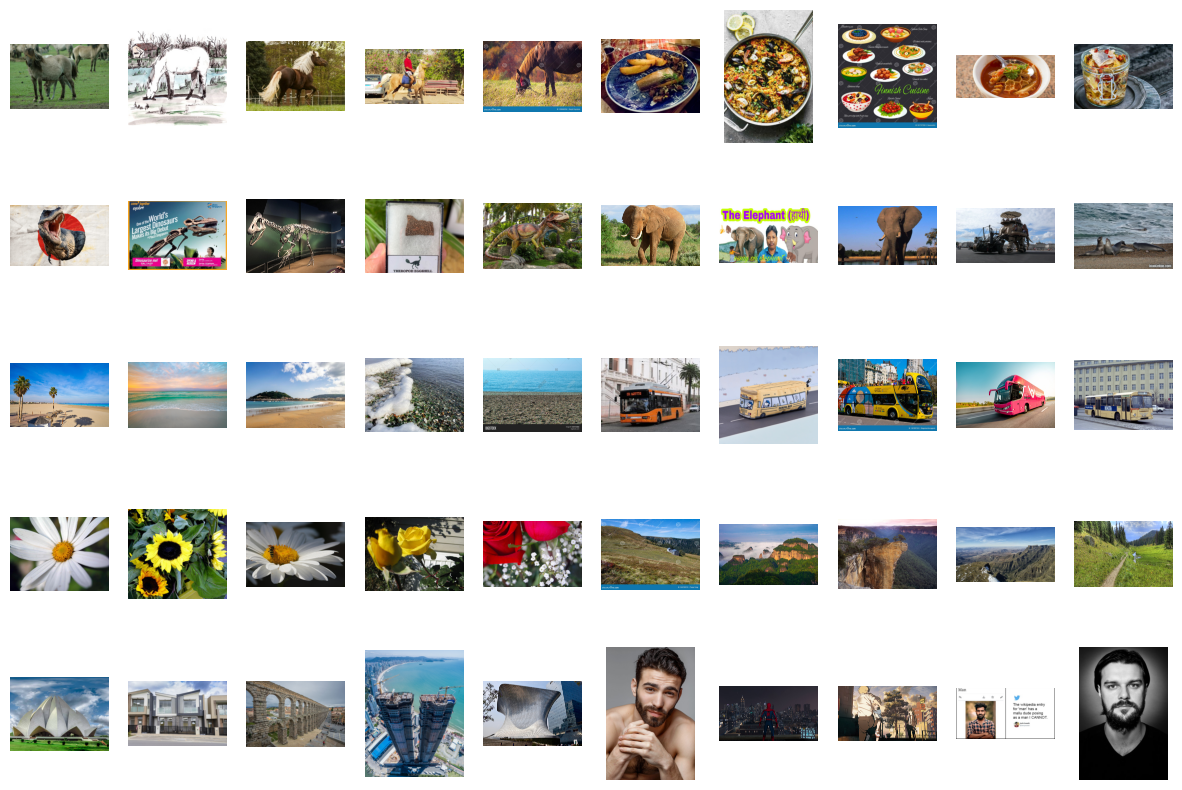

In [60]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].sample(5).values
    for sample in samples:
        random_samples.append(sample)

# # Plot the samples
f, ax = plt.subplots(5,10, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//10,i%10].imshow(mimg.imread(random_samples[i]))
    ax[i//10,i%10].axis('off')
plt.show()    


In [61]:
for type in image_types:
    %mkdir -p {DATA_TRAIN_DIR}/{type}
    %mkdir -p {DATA_VALID_DIR}/{type}

In [62]:
for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],DATA_VALID_DIR+'/' + str(category) + '/'+ name)

    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],DATA_TRAIN_DIR+'/' + str(category) + '/' + name)

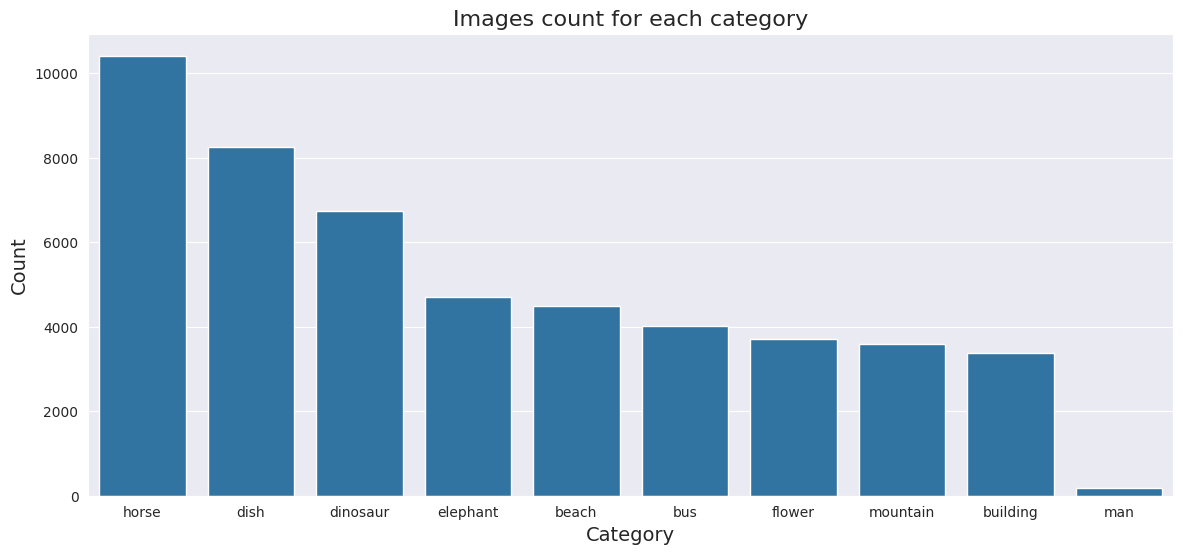

In [63]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = ds_image_count.index, y = ds_image_count.values, ax = axe)
axe.set_title("Images count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

In [64]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_w, image_h, 3)
)

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    # starting from block5_conv1, train the layers and layers following
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Feature Extraction

In [65]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(image_types), activation='softmax'))


model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 10)               

In [66]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        DATA_TRAIN_DIR,
        target_size=(image_w, image_h),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical'  # more than two classes
)

validation_generator = test_datagen.flow_from_directory(
        DATA_VALID_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)


test_generator = test_datagen.flow_from_directory(
        DATA_TEST_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 48477 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [67]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_acc', 
    mode='max', patience=early_stopping_patience,  
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
    )

Epoch 1/5


2024-11-22 12:25:32.979375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:25:33.127880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 12:25:33.127938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 12:25:33.127979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-22 12:25:33.128004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

50/50 [==============================] - ETA: 0s - loss: 0.3609 - acc: 0.2237

2024-11-22 12:26:04.716625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 12:26:04.786468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 12:26:04.786510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 12:26:04.786543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-22 12:26:04.786557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

50/50 [==============================] - 38s 734ms/step - loss: 0.3609 - acc: 0.2237 - val_loss: 0.2763 - val_acc: 0.3219
Epoch 2/5
50/50 [==============================] - 37s 744ms/step - loss: 0.2806 - acc: 0.3650 - val_loss: 0.2108 - val_acc: 0.5906
Epoch 3/5
50/50 [==============================] - 38s 752ms/step - loss: 0.2537 - acc: 0.4506 - val_loss: 0.2153 - val_acc: 0.5500
Epoch 4/5
50/50 [==============================] - 38s 757ms/step - loss: 0.2310 - acc: 0.5131 - val_loss: 0.1769 - val_acc: 0.6188
Epoch 5/5
50/50 [==============================] - 38s 757ms/step - loss: 0.2194 - acc: 0.5531 - val_loss: 0.1751 - val_acc: 0.5969


In [68]:
model.save(MODEL_DIR+'/model.h5')

with open(MODEL_DIR+'/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

with open(MODEL_DIR+'/model_architecture.json', 'w') as f:
    f.write(model.to_json())

history.history.keys()

INFO:tensorflow:Assets written to: ram://461f8609-68ba-4b49-8622-39f86588fd44/assets


INFO:tensorflow:Assets written to: ram://461f8609-68ba-4b49-8622-39f86588fd44/assets


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

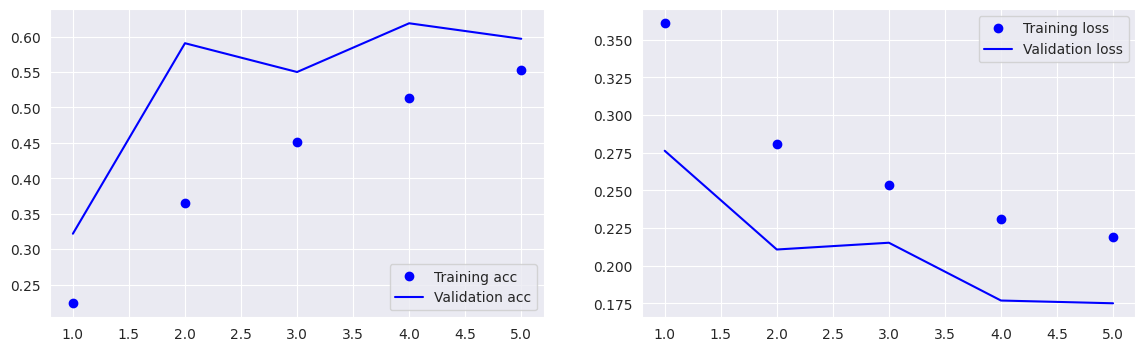

In [69]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [70]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.596875011920929


32/32 [==============================] - 16s 517ms/step


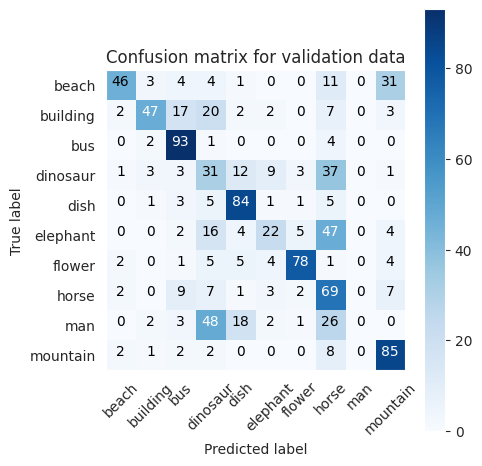

In [73]:
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(
    title='Confusion matrix for validation data',
    cm = con_mat, 
    classes = validation_generator.class_indices.keys(), 
    normalize = False
    )

32/32 [==============================] - 18s 564ms/step


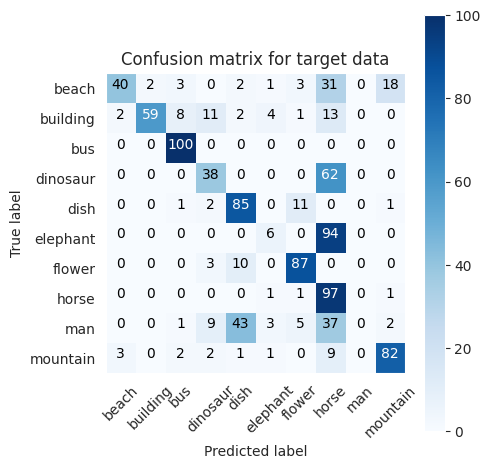

In [74]:
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(test_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(
    title='Confusion matrix for target data',
    cm = con_mat, 
    classes = test_generator.class_indices.keys(), 
    normalize = False
    )

In [ ]:
!rm -rf /home/logic/.keras/datasets/Red_sunflower
# bus
sunflower_url = "https://images.unsplash.com/photo-1540457943340-2e70b692e50e"
# sunflower_url = "https://images.unsplash.com/photo-1590951360207-317cb18098b3"
# sunflower_url = "https://images.unsplash.com/photo-1491378630646-3440efa57c3b"
# sunflower_url = "https://images.unsplash.com/photo-1499190263783-18a53a561660"
sunflower_url = "https://images.unsplash.com/photo-1527576539890-dfa815648363"

# sunflower_url = "https://images.unsplash.com/photo-1544954412-78da2cfa1a0c"
# sunflower_url = "https://images.unsplash.com/photo-1550927049-d07581451e3c"
# sunflower_url = "https://images.unsplash.com/photo-1462216589242-9e3e00a47a48"
# sunflower_url = "https://images.unsplash.com/photo-1533523611631-15e4ef69be08"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# train
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/train/tulips/17189526216_fa24dd541a_n.jpg"

# validation
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/dandelion/10683189_bd6e371b97.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/roses/159079265_d77a9ac920_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"

img = tf.keras.utils.load_img(    sunflower_path, target_size=(image_h, image_w))

img


In [ ]:
class_names = list(validation_generator.class_indices.keys())

import pandas as pd

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

data = np.array([class_names,predictions[0]])
print(pd.DataFrame(data))


### 85% Accuracy using VGG16.